In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Data Preprocessing

In [5]:
import tensorflow
print(tensorflow.__version__)

2.3.0


In [6]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 3.9MB 37.4MB/s 
     |████████████████████████████████| 450kB 38.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=2406bce3ad894d029226e417f59e195fc2e023109516ca4c3891282cf3749df5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [1]:
import tensorflow
print(tensorflow.__version__)
print(tensorflow.keras.__version__)

2.1.0
2.2.4-tf


In [1]:
# import library
import os

# set directory path for dataset
os.chdir("/content/drive/My Drive/Colab_Project/Face_Mask_Detection")
Dataset = 'dataset'
Data_Dir = os.listdir(Dataset)
print(Data_Dir)

['without_mask', 'with_mask']


In [2]:
# import necessary library
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

img_rows, img_cols = 112, 112

images = []     # Contain all the images after performing the gray scalling
labels = []     # Contain all the label of the images. i.e 'with mask' or 'without mask'

for category in Data_Dir :
  folder_path = os.path.join(Dataset, category)
  for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img)
    img = cv2.imread(img_path)

    try:
      # converting the image into gray scale
      grayscale_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

      # resizing the grayscaled image into size 56x56 in order to keep size of the images consistent
      resized_img = cv2.resize(grayscale_img, (img_rows, img_cols))
      images.append(resized_img)
      labels.append(category)
    # Exception Handling in case any error occurs
    except Exception as e:
      print('Exception : ',e)

images = np.array(images)/255.0
images = np.reshape(images, (images.shape[0], img_rows, img_cols, 1))

# perform one hot encoding on the labels since the label are in textual form
lb = LabelBinarizer()
labels = lb.fit_transform(labels) # apply LabelBinarizer on each label

labels = to_categorical(labels) # to convert label in to OneHotEncoded form

labels = np.array(labels) # convert into array

(train_X, test_X, train_y, test_y) = train_test_split(images, labels, test_size = 0.2, random_state=0)

In [3]:
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Build A Convolution Neural Networ (CNN) Classification Model

In [4]:
# import necessary keras library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Define model parameters
num_classes = 2
batch_size = 32

# Build CNN model using sequential API
model = Sequential()

# First layer group containing Convolution, Relu and MaxPooling layers
model.add(Conv2D(200,(3,3),input_shape = (img_rows, img_cols, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Second layer group containing Convolution, Relu and MaxPooling layers
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Flatten and Dropout layer to stack the output convolutions above as well as cater overfitting
model.add(Flatten())
model.add(Dropout(0.5))

# Softmax Classifier
model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 200)     2000      
_________________________________________________________________
activation (Activation)      (None, 110, 110, 200)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67600)             0

# Train the Model

In [6]:
from tensorflow.keras.optimizers import Adam

epochs = 50

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

fitted_model = model.fit(train_X, train_y, epochs = epochs, validation_split = 0.25)

Train on 825 samples, validate on 275 samples
Epoch 1/50
825/825 [==============================] - 85s 103ms/sample - loss: 0.7898 - accuracy: 0.5018 - val_loss: 0.7271 - val_accuracy: 0.5273
Epoch 2/50
825/825 [==============================] - 86s 104ms/sample - loss: 0.6509 - accuracy: 0.6073 - val_loss: 0.5731 - val_accuracy: 0.7636
Epoch 3/50
825/825 [==============================] - 90s 109ms/sample - loss: 0.4786 - accuracy: 0.7830 - val_loss: 0.3765 - val_accuracy: 0.8509
Epoch 4/50
825/825 [==============================] - 90s 110ms/sample - loss: 0.3315 - accuracy: 0.8630 - val_loss: 0.3119 - val_accuracy: 0.8618
Epoch 5/50
825/825 [==============================] - 84s 102ms/sample - loss: 0.2703 - accuracy: 0.8800 - val_loss: 0.2951 - val_accuracy: 0.8691
Epoch 6/50
825/825 [==============================] - 84s 102ms/sample - loss: 0.2524 - accuracy: 0.9006 - val_loss: 0.2845 - val_accuracy: 0.8836
Epoch 7/50
825/825 [==============================] - 82s 100ms/sample -

# Plot rhe Training Loss & Accuracy

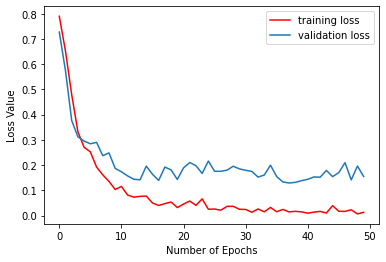

In [7]:
from matplotlib import pyplot as plt
# plot trainin and validation loss
plt.plot(fitted_model.history['loss'], 'r', label='training loss')
plt.plot(fitted_model.history['val_loss'], label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

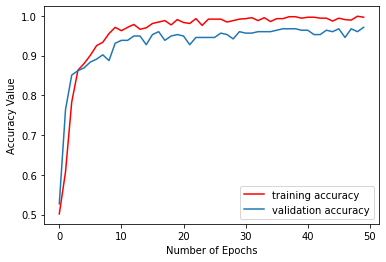

In [8]:
# plot trainin and validation loss
plt.plot(fitted_model.history['accuracy'], 'r', label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

# Save or Serialize the Model

In [9]:
# Save or Serialize the model with the namme face_mask_detection_alert_system
model.save('fmd_tf_2-1-0_2-2-4-tf.h5')